有效文献数：129
Network  节点数: 21 边数: 32

Top-10 核心关键词：
          Degree  Betweenness  Eigenvector
粤港澳大湾区       20     0.921053     0.644166
门槛效应          4     0.005263     0.245697
经济增长          4     0.005263     0.245697
高质量发展         3     0.002632     0.191340
区域差异          3     0.000000     0.218136
制造业           3     0.002632     0.191340
税收协调          2     0.000000     0.153154
驱动机制          2     0.000000     0.153154
金融集聚          2     0.000000     0.170925
经济高质量发展       2     0.000000     0.153154


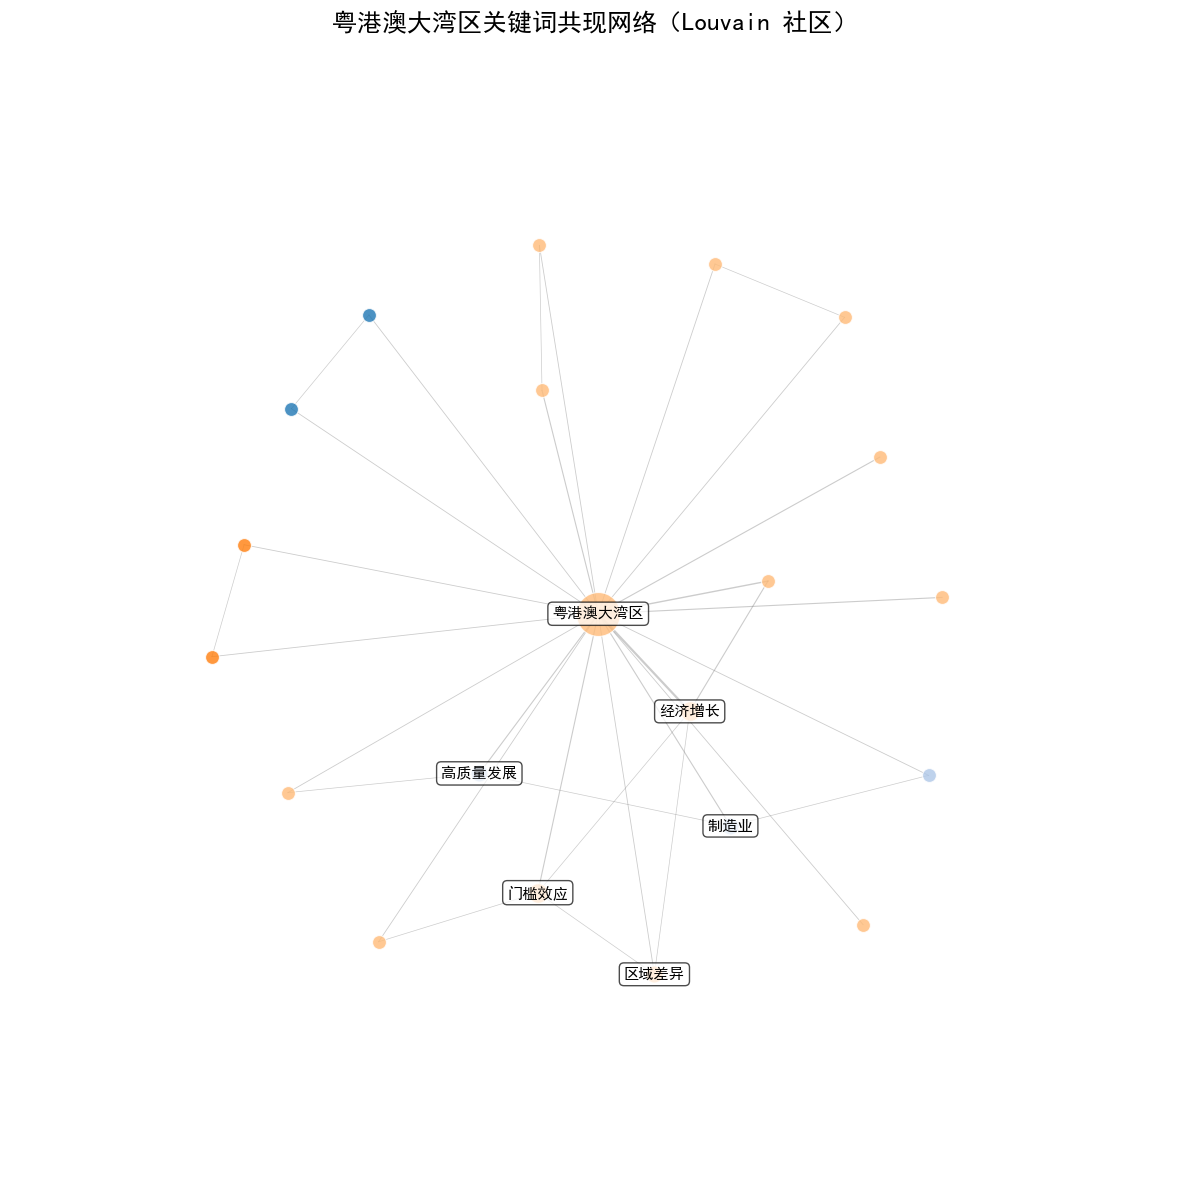


✅ 已生成文件：
  - 共现矩阵.csv（关键词共现数据）
  - 知识图谱.pdf/png（可视化图谱）
  - 知识图谱.graphml（Gephi兼容格式）


In [11]:
# build_knowledge_graph.py
# -*- coding: utf-8 -*-
import re, pandas as pd, networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from networkx.algorithms import community   # Louvain 社区检测

IN_FILE   = 'cnki.txt'
TOP_K     = 30        # 减少关键词数量，避免稠密图
CO_TH     = 3         # 提高共现阈值，稀疏化矩阵
STOP_WORD = {
    '研究', '分析', '影响', '比较', '基于', '以', '为例', '及', '其', '对', '的', '与',
    '制度性', '集体行动', '问题', '策略', '路径', '机制', '发展', '建设'  # 新增高频无意义停用词
}
# ---------------------------------------------

# 1. 解析 CNKI 文本
def parse_cnki(path):
    """返回 List[str] 每篇文章的关键词字符串"""
    try:
        with open(path, encoding='utf-8') as f:
            txt = f.read()
    except FileNotFoundError:
        print(f"错误：未找到文件 {IN_FILE}，请在代码同目录创建！")
        return []
    # 正则提取“关键词：xxx”行
    keys = re.findall(r'关键词：(.+?)\n', txt)
    if not keys:
        print("警告：未提取到关键词！请检查cnki.txt格式（需包含“关键词：xxx”）")
        return []
    # 清洗 & 分割
    clean = []
    for line in keys:
        # 替换所有分隔符为空格
        line_clean = line.strip().replace('；', ' ').replace(';', ' ').replace('，', ' ').replace(',', ' ')
        # 分割+去重+过滤
        words = list(dict.fromkeys(line_clean.split()))  # 去重
        words = [w for w in words if w not in STOP_WORD and len(w) > 1]
        words = words[:8]  # 限制每篇文档最多8个关键词，避免稠密
        if len(words) >= 2:  # 至少保留2个关键词才计入
            clean.append(' '.join(words))
    return clean

docs = parse_cnki(IN_FILE)
if not docs:
    exit()  # 无数据则退出
print(f"有效文献数：{len(docs)}")

# 2. 构建词频矩阵
vectorizer = CountVectorizer(token_pattern=r'(?u)\b\w+\b', max_features=TOP_K, binary=True)
X = vectorizer.fit_transform(docs)
vocab = vectorizer.get_feature_names_out()
if len(vocab) == 0:
    print("错误：无有效关键词！请检查cnki.txt内容")
    exit()
df_bool = pd.DataFrame(X.toarray(), columns=vocab)

# 3. 共现矩阵
co_matrix = df_bool.T @ df_bool
# 对角线清零
co_matrix.values[tuple([range(co_matrix.shape[0])]*2)] = 0  
# 按阈值过滤（只保留共现≥CO_TH的边）
co_matrix = co_matrix.loc[:, (co_matrix >= CO_TH).any(axis=0)]  # 过滤列
co_matrix = co_matrix.loc[(co_matrix >= CO_TH).any(axis=1), :]  # 过滤行
co_matrix.to_csv('共现矩阵.csv', encoding='utf-8-sig')

# 4. 转 NetworkX（容错处理空图）
if co_matrix.empty:
    print(f"错误：无满足共现阈值{CO_TH}的关键词对！请降低CO_TH值")
    exit()
G = nx.from_pandas_adjacency(co_matrix)
G = G.to_undirected()
print('Network  节点数:', G.number_of_nodes(), '边数:', G.number_of_edges())
if G.number_of_edges() == 0:
    print("错误：无可用边，无法绘制图谱！请降低CO_TH值")
    exit()

# 5. 中心性计算
centrality = pd.DataFrame({
    'Degree'      : dict(G.degree()),
    'Betweenness' : nx.betweenness_centrality(G, normalized=True),
    'Eigenvector' : nx.eigenvector_centrality(G, max_iter=2000, tol=1e-4, weight=None),
}).sort_values('Degree', ascending=False)
print('\nTop-10 核心关键词：\n', centrality.head(10))

# 6. 社区检测（Louvain）
communities = community.louvain_communities(G, seed=42)
palette = sns.color_palette('tab20', len(communities))
color_map = {n: palette[i] for i, com in enumerate(communities) for n in com}

# 7. 绘图（核心修复：布局容错+原生绘制）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'PingFang SC']
plt.rcParams['axes.unicode_minus'] = False
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 节点布局（稳定化+容错）
if G.number_of_nodes() > 1:
    # 优先用spring布局，失败则降级为圆形布局
    try:
        pos = nx.spring_layout(G, k=0.3, iterations=80, seed=42, scale=1.0)
    except:
        pos = nx.circular_layout(G)
else:
    pos = {list(G.nodes)[0]: (0, 0)}  # 单节点容错

# 容错处理：替换无穷/NaN值为有限值
for node in pos:
    pos[node] = np.nan_to_num(pos[node], nan=0.0, posinf=1.0, neginf=-1.0)

# 绘制节点
deg = dict(G.degree())
node_sizes = [max(v*50, 100) for v in deg.values()]  # 节点大小兜底
node_colors = [color_map[n] for n in G.nodes]
for i, (node, (x, y)) in enumerate(pos.items()):
    ax.scatter(
        x, y, 
        s=node_sizes[i], 
        c=[node_colors[i]], 
        alpha=0.8, 
        edgecolors='white', 
        linewidth=0.8,
        zorder=2  # 节点在边上方
    )

# 绘制边（原生matplotlib，彻底绕过networkx bug）
weights = [G.edges[u, v].get('weight', 1) for u, v in G.edges]
for i, (u, v) in enumerate(G.edges):
    x1, y1 = pos[u]
    x2, y2 = pos[v]
    # 绘制单条边，宽度按共现次数
    ax.plot(
        [x1, x2], [y1, y2], 
        color='gray', 
        alpha=0.4, 
        linewidth=max(weights[i]*0.2, 0.5),  # 边宽度兜底
        zorder=1  # 边在节点下方
    )

# 绘制标签
lab_threshold = max(2, int(G.number_of_nodes() * 0.1))  # 动态阈值
lab = {n: n for n in G.nodes if deg[n] > lab_threshold}
for node, label in lab.items():
    x, y = pos[node]
    ax.text(
        x, y, label, 
        fontsize=11, 
        ha='center', 
        va='center', 
        zorder=3,  # 标签在最上方
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)  # 标签背景
    )

# 美化图谱
ax.set_title('粤港澳大湾区关键词共现网络（Louvain 社区）', fontsize=18, pad=20)
ax.axis('off')  # 隐藏坐标轴
ax.set_xlim([-1.5, 1.5])  # 固定坐标范围
ax.set_ylim([-1.5, 1.5])

# 保存图谱（防重叠）
plt.tight_layout()
plt.savefig('知识图谱.pdf', dpi=300, bbox_inches='tight')
plt.savefig('知识图谱.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. 导出 Gephi
nx.write_graphml(G, '知识图谱.graphml')
print('\n✅ 已生成文件：')
print('  - 共现矩阵.csv（关键词共现数据）')
print('  - 知识图谱.pdf/png（可视化图谱）')
print('  - 知识图谱.graphml（Gephi兼容格式）')